In [46]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [47]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [49]:
#Setting path to the database file
database_path = "Resources/hawaii.sqlite"


In [50]:
# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

# engine = create_engine("sqlite:///hawaii.sqlite")
# conn = engine.connect()

In [102]:
#This only works with the name of the tables..NOT the file!
hawaii_df = pd.read_sql("SELECT * FROM station", conn)
hawaii_df.head()



,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [87]:
measure_df = pd.read_sql("SELECT * FROM measurement", conn)
measure_df


,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
...,...,...,...,...,...
19545,19546,USC00516128,2017-08-19,0.09,71.0
19546,19547,USC00516128,2017-08-20,NaN,78.0
19547,19548,USC00516128,2017-08-21,0.56,76.0
19548,19549,USC00516128,2017-08-22,0.50,76.0


In [53]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables

Base.prepare(engine, reflect = True)

In [54]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [55]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [56]:
# Create our session (link) from Python to the DB
session = Session(engine)


In [57]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c986a03460>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [58]:
for row in session.query(Measurement, Measurement.date).limit(5).all():
    print(row)

(<sqlalchemy.ext.automap.measurement object at 0x000001C986A03490>, '2010-01-01')
(<sqlalchemy.ext.automap.measurement object at 0x000001C986ACC520>, '2010-01-02')
(<sqlalchemy.ext.automap.measurement object at 0x000001C986A03940>, '2010-01-03')
(<sqlalchemy.ext.automap.measurement object at 0x000001C986A039D0>, '2010-01-04')
(<sqlalchemy.ext.automap.measurement object at 0x000001C986A03A30>, '2010-01-06')


In [59]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1c986a03f10>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'station': 'USC00519397'}

In [60]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [61]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [62]:
# Find the most recent date in the data set.

#I can't believe this works, as this is a text column...
engine.execute('SELECT MAX(date) FROM Measurement').fetchall()



[('2017-08-23',)]

Query Date:  2016-08-23


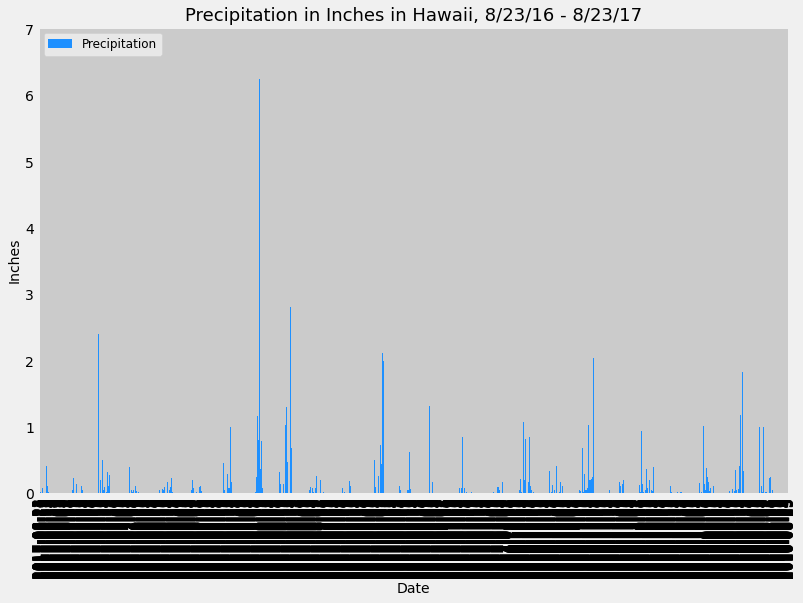

In [98]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.


# Calculate the date one year from the last date in data set.
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

#Show the calculated year
print("Query Date: ", last_year)

#Run query to gather precip data for one year
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= last_year).all()
precip

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip)
reset_precip_df = precip_df.set_index('date')

# Sort the dataframe by date
sorted_precip_df = reset_precip_df.sort_values(by= 'date', ascending = False, inplace=False)
sorted_precip_df

# Use Pandas Plotting with Matplotlib to plot the data

#Plot the bar chart with title
sorted_precip_df.plot(kind = "bar", color = "dodgerblue", figsize = (12,8))



#Add title and labels for each axis and set font size.
plt.title("Precipitation in Inches in Hawaii, 8/23/16 - 8/23/17", fontsize = (18))
plt.ylabel("Inches", fontsize = (14))
# plt.xticks(rotation = 45, fontsize = (12))
plt.xlabel("Date", fontsize = (14))
plt.legend(["Precipitation"], loc = "best", prop={"size": 12})

#Display the chart
plt.show()



In [84]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [111]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.station).count()
print(stations)

9


In [115]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
for station, count in active_station:
    print(station, count)


USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [148]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_data = session.query(Measurement.station, Measurement.tobs).filter(Measurement.station == "USC00519281").all()
active_data


#Probably not the way I'm supposed to do it, but this method works...make into a df and do aggregate calculations
active_data_df = pd.DataFrame(active_data)
active_data_df
active_data_df.groupby(["station"])["tobs"].agg(['min', 'max', 'mean'])






,min,max,mean
station,,,
USC00519281,54.0,85.0,71.663781


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()